# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 2
BATCH_SIZE: int = 16

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


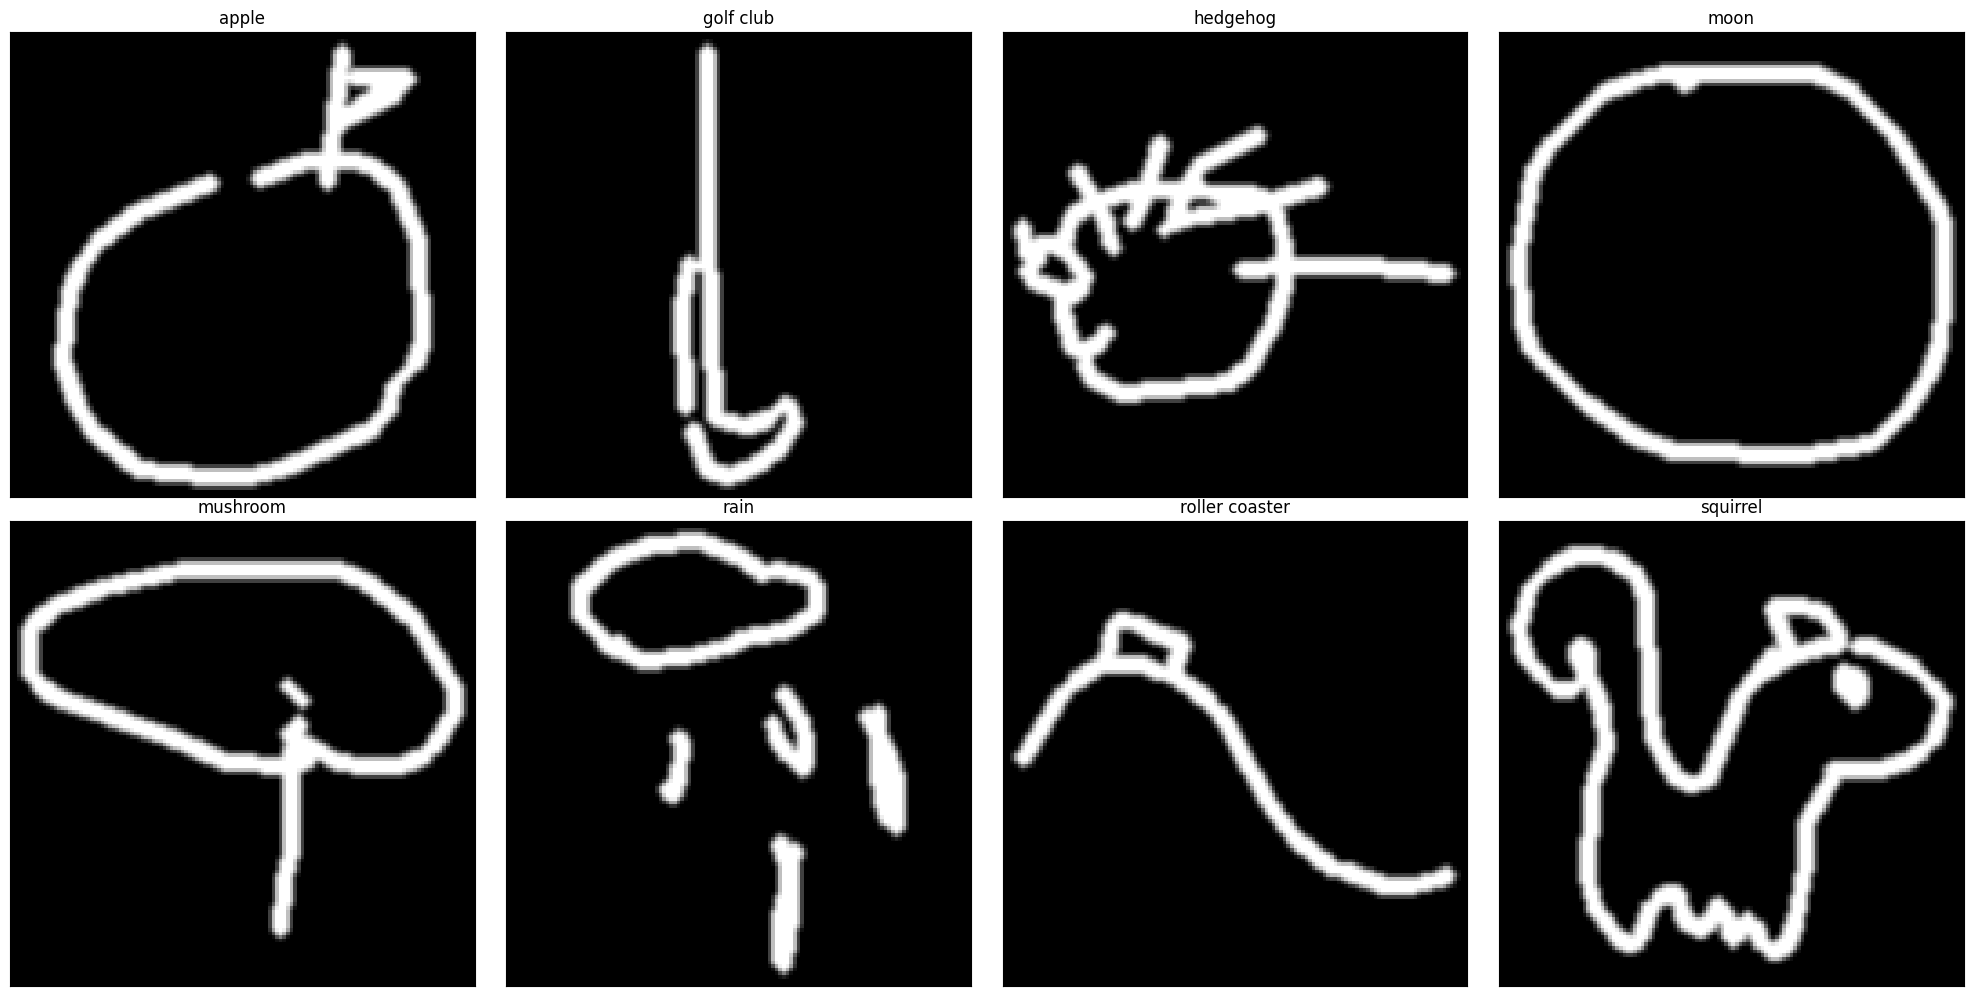

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 2000
valid_test_subset = 500

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
def dataset_distribution(classes, dataset):
    distrib = {i: 0 for i in range(len(classes))}

    for i in range(dataset.__len__()):
        _, label = dataset.__getitem__(i)
        distrib[label]+=1

    return distrib

In [10]:
print(f'training set distribution :\n{dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{dataset_distribution(classes, test_set)}')

training set distribution :
{0: 283, 1: 262, 2: 248, 3: 242, 4: 237, 5: 243, 6: 255, 7: 230}
validation set distribution :
{0: 72, 1: 59, 2: 58, 3: 56, 4: 61, 5: 57, 6: 64, 7: 73}
test set distribution :
{0: 63, 1: 50, 2: 48, 3: 77, 4: 64, 5: 66, 6: 69, 7: 63}


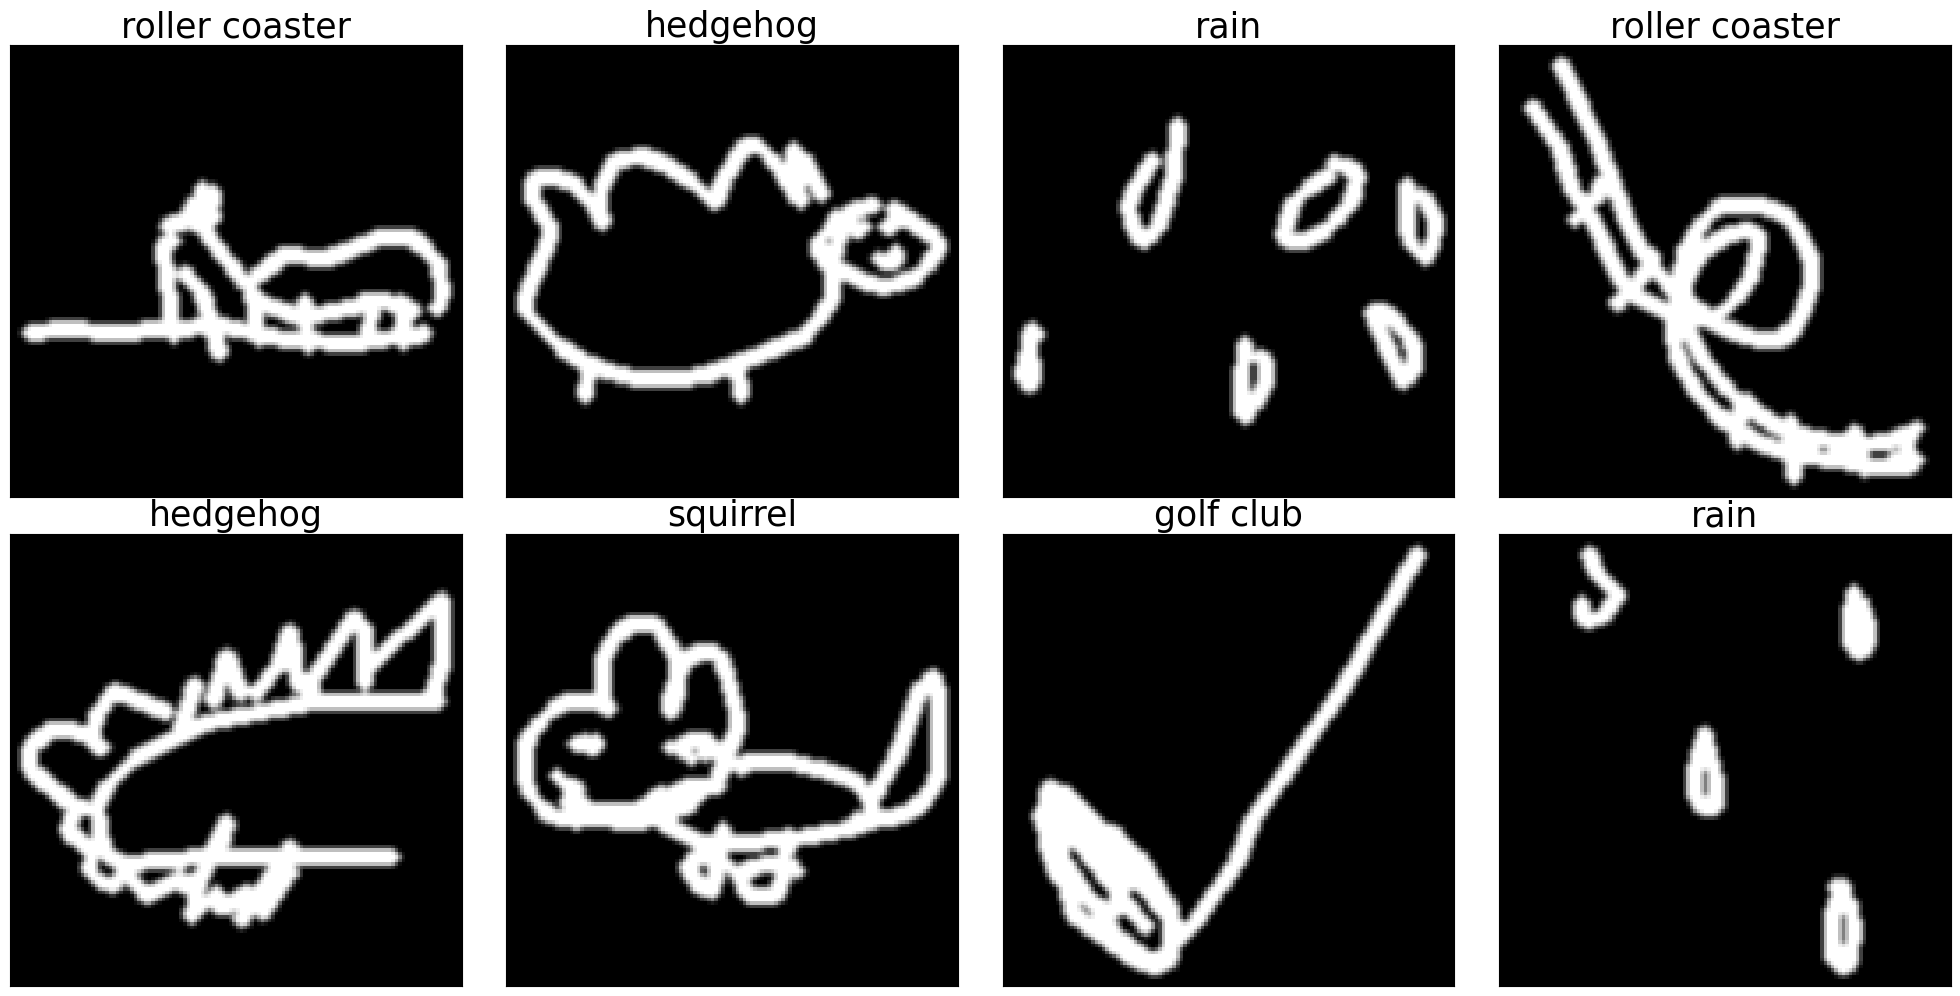

In [11]:
# Show some images
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(numb_rows*numb_cols):
    index = random.randint(0, len(training_set)-1)
    ax = axes[i//numb_cols, i%numb_cols]

    img, label_index = training_set[index]

    ax.imshow(training_set.convert_to_img(img), cmap='gray')
    ax.set_title(classes[label_index], fontsize=25)

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Autoencoder class

In [12]:
from src.conv_autoencoder import ConvAutoencoder
from src.conv_autoencoder_embed import ConvAutoencoderEmbed

## Try with simple model

In [13]:
architecture_1 = [1, 8, 16]
autoencoder_model = ConvAutoencoderEmbed(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [14]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {(len(architecture_1)-2)*2}')

Sequential(
  (encoder_0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ReLU()
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (decoder_2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_relu_2): ReLU()
  (encoder_upsample_2): Upsample(scale_factor=2.0, mode='nearest')
  (encoder_dropout_2): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_1): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2


In [15]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def numpy_to_tensor(numpy_array):
    return torch.from_numpy(numpy_array.astype(np.float32)).to(device)

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [16]:
# Call the function
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, EPOCHS)

Epoch [1/2] T Loss: 0.0168 V Loss: 0.0152 T PSNR: 18.3815 T SSIM: 0.2747 V PSNR: 18.4010 V SSIM: 0.2706
Epoch [2/2] T Loss: 0.0066 V Loss: 0.0066 T PSNR: 22.3584 T SSIM: 0.3176 V PSNR: 22.3882 V SSIM: 0.3132


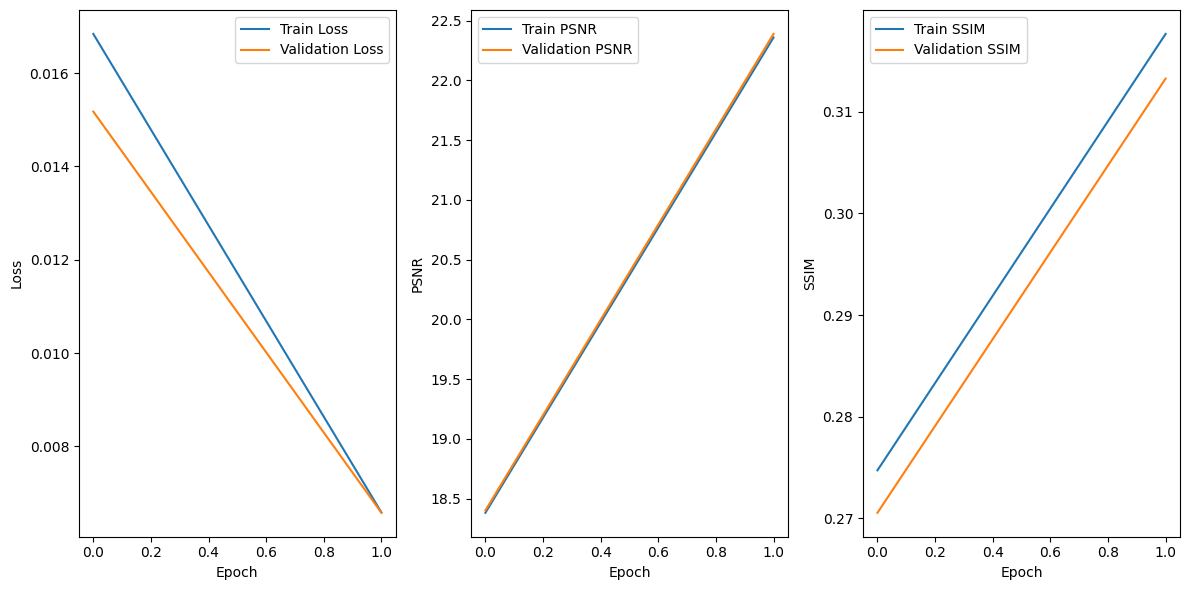

In [17]:
autoencoder_model.plot_psnr_ssim()

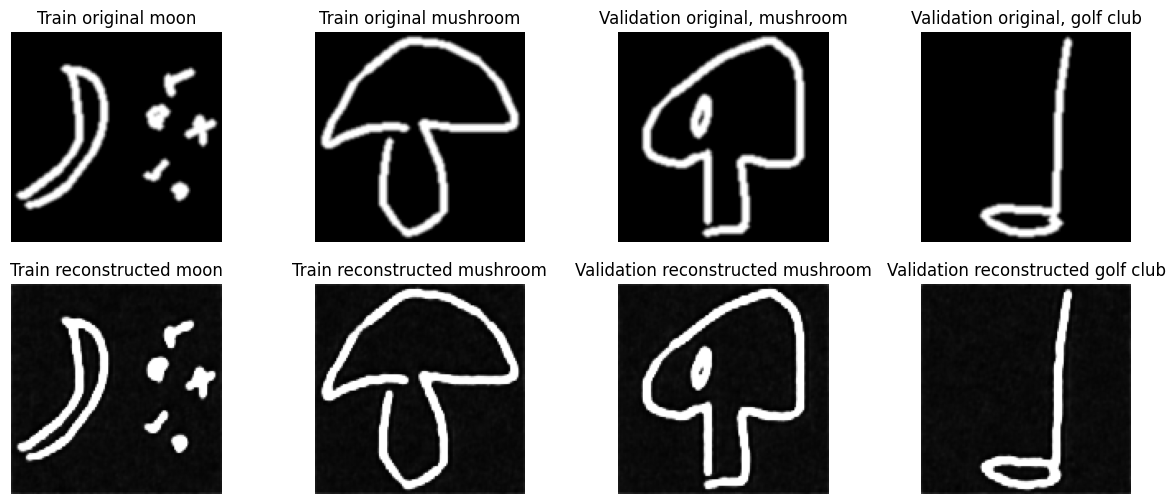

In [18]:
autoencoder_model.show_images(training_set, validation_set)

In [19]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [20]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 246|20.175988398591407, Lowest SSIM index: 259|0.10382009576549325


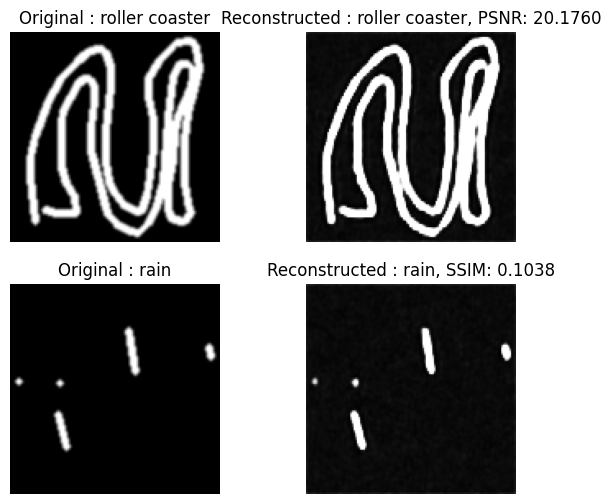

In [21]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

# Show latent space

In [51]:
from sklearn.decomposition import PCA

def latent_space_visualization(model, valid_loader, use_embedding=False):
    model.eval()
    pca = PCA(n_components=2)

    points = []
    label_idcs = []
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
            
        pack = model(inputs, labels)
        proj = pack["encoded_before" if use_embedding else "encoded"]
        for i in range(inputs.size(0)):
            encoded = tensor_to_numpy(proj[i])

            # Reshape to flatten in order to get one dimension
            if len(encoded.shape) > 1:
                encoded = encoded.reshape(-1)

            points.append(encoded)

            label_idcs.append(labels[i].detach().cpu().numpy())

            # print advancement
            
            if len(points) % 100 == 0:
                print(f'points: {len(points)}')
    points = np.array(points)
    points = pca.fit_transform(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)

    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)

    plt.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
    plt.show()

points: 100
points: 200
points: 300
points: 400
points: 500
points: 600
points: 700
points: 800
points: 900
points: 1000
points: 1100
points: 1200
points: 1300
points: 1400
points: 1500
points: 1600
points: 1700
points: 1800
points: 1900
points: 2000


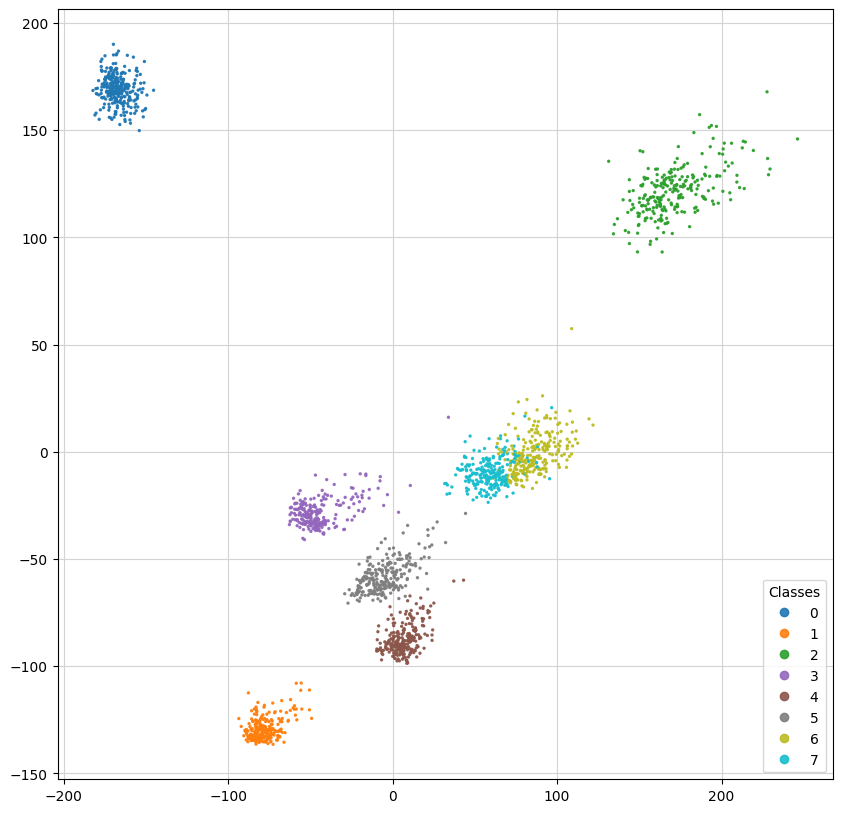

In [52]:
latent_space_visualization(autoencoder_model, training_loaded_set)

## Generating images

In [ ]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

Class apple range of mean encoded vector: [-4.615854740142822, 4.787319569974332]
Class golf club range of mean encoded vector: [-4.692122961997986, 5.22375216293335]
Class hedgehog range of mean encoded vector: [-4.943673060122264, 4.984369597760549]
Class moon range of mean encoded vector: [-4.574351932189261, 4.395545597224272]
Class mushroom range of mean encoded vector: [-4.214069525400798, 5.032802955839369]
Class rain range of mean encoded vector: [-4.49306826298848, 4.963643807366436]
Class roller coaster range of mean encoded vector: [-4.664454777394572, 4.905437903058145]
Class squirrel range of mean encoded vector: [-4.637015611697466, 4.314160151359363]


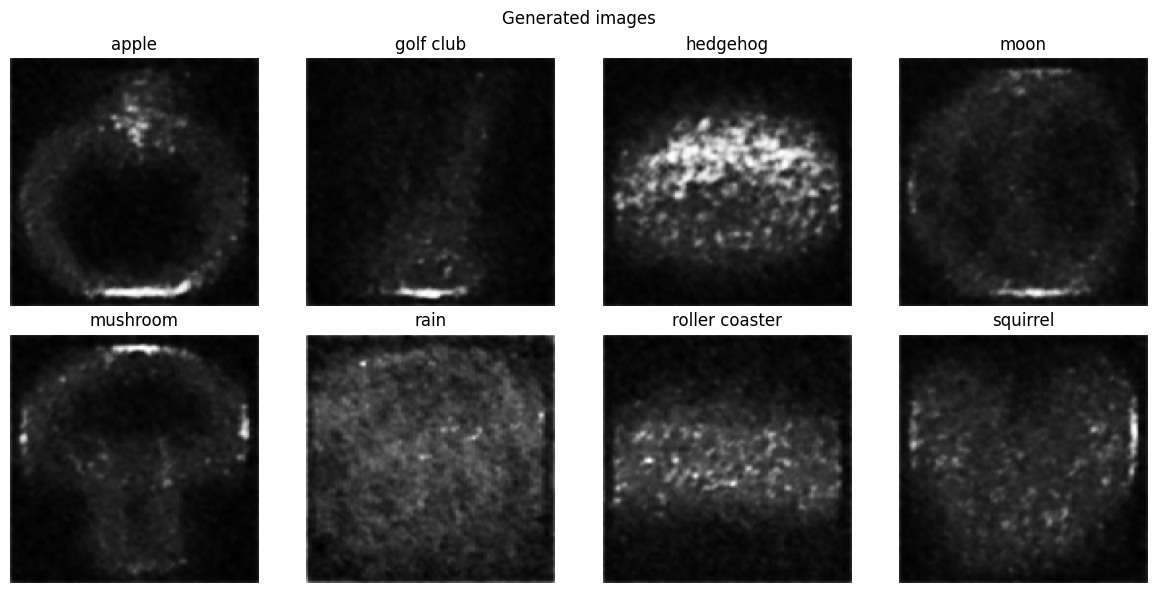

In [ ]:
mean_encoded_vectors = image_generator.generate_mean_encoded_vectors_per_classes(training_loaded_set)
image_generator.show_generated_images_per_mean_vectors(mean_encoded_vectors)

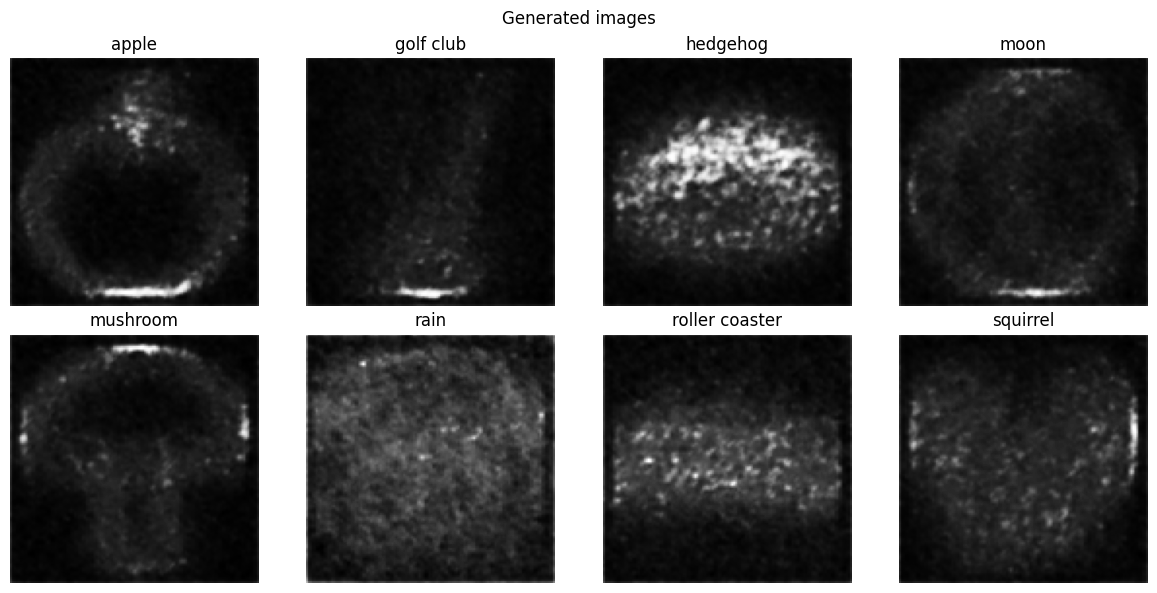

In [ ]:
noised_encoded_vectors = image_generator.generate_noised_mean_vectors(mean_encoded_vectors, 0.05)
image_generator.show_generated_images_per_mean_vectors(noised_encoded_vectors)

## Interpolation

### z_embed class (n) => z_embed' class (n)

torch.Size([1, 128, 128])
8


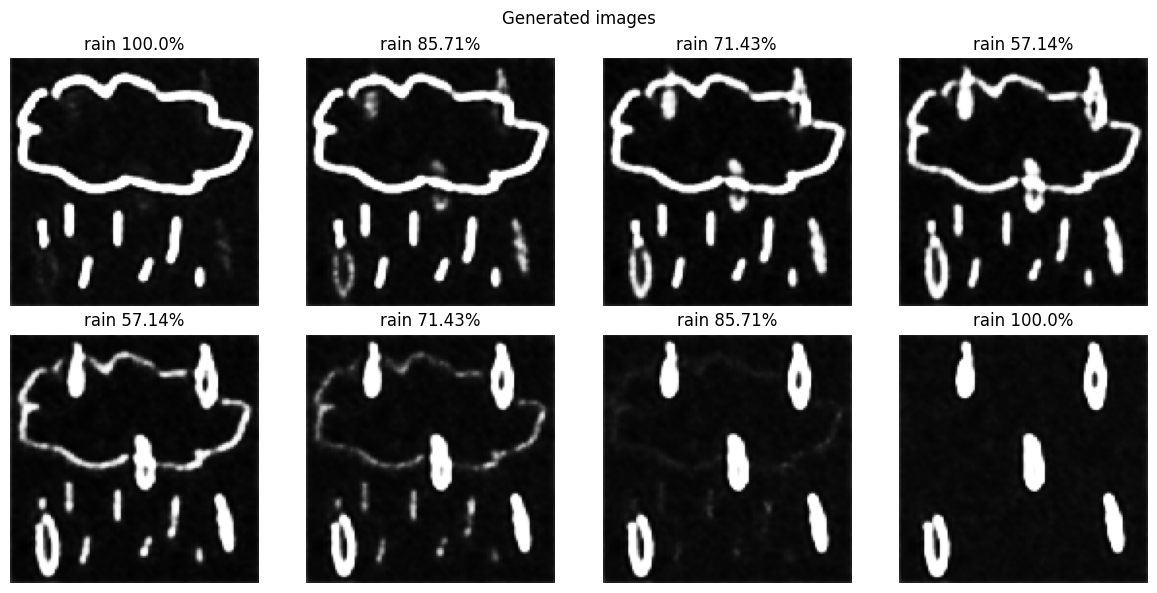

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)

print(image_1.unsqueeze(0).shape)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))


# iterate over all images to find the first image with the same label
indice2 = 1
image_2, label2 = None, None

while label2 != label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)

pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_embed_space1 = pack1["encoded"].cpu().detach().numpy()
latent_embed_space2 = pack2["encoded"].cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))


### z_embed class (n) => z_embed' class (m, n != m)

8


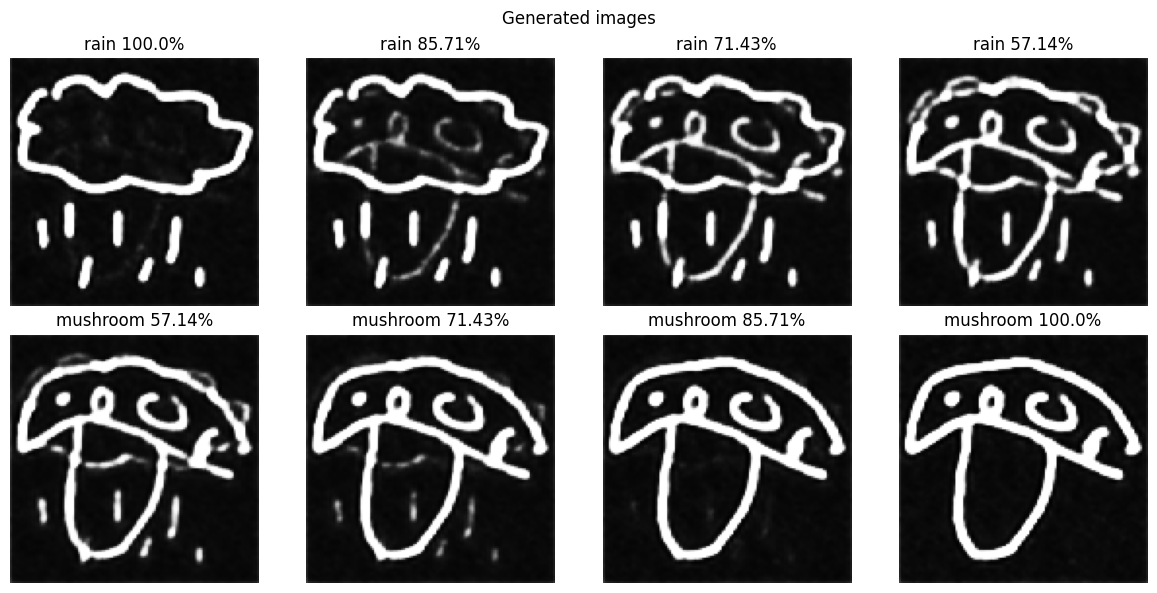

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_embed_space1 = pack1["encoded"].cpu().detach().numpy()
latent_embed_space2 = pack2["encoded"].cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class n => z' (class m, n != m) + embed_class n

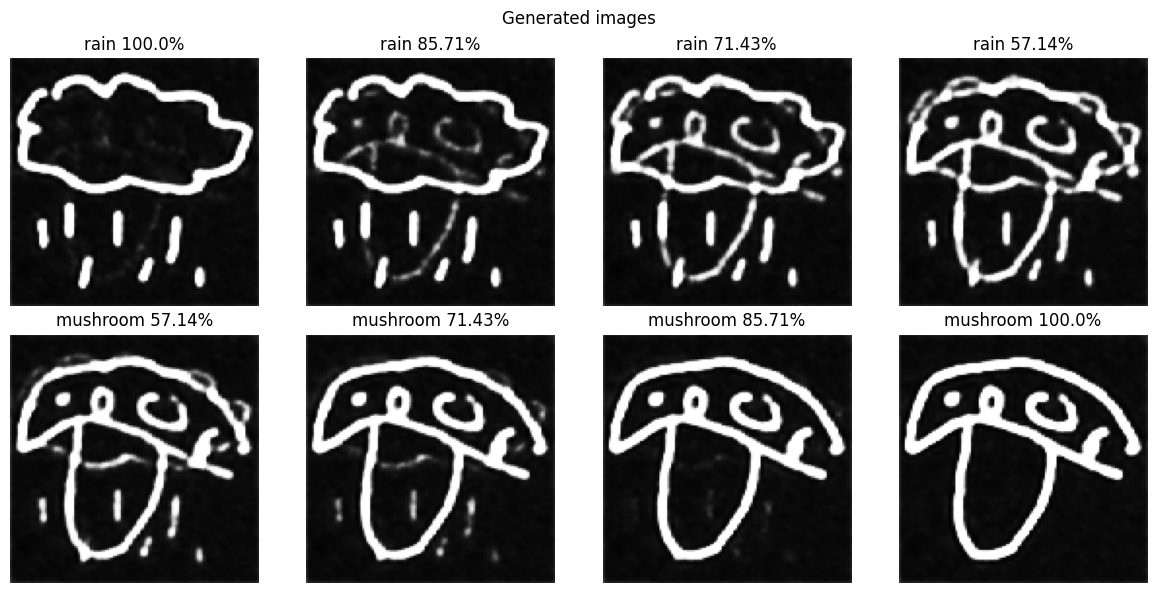

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]

embed_class1 = autoencoder_model.get_embed(label1.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class1).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class1).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)
    
image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class m => z' (class m, n != m) + embed_class m

8


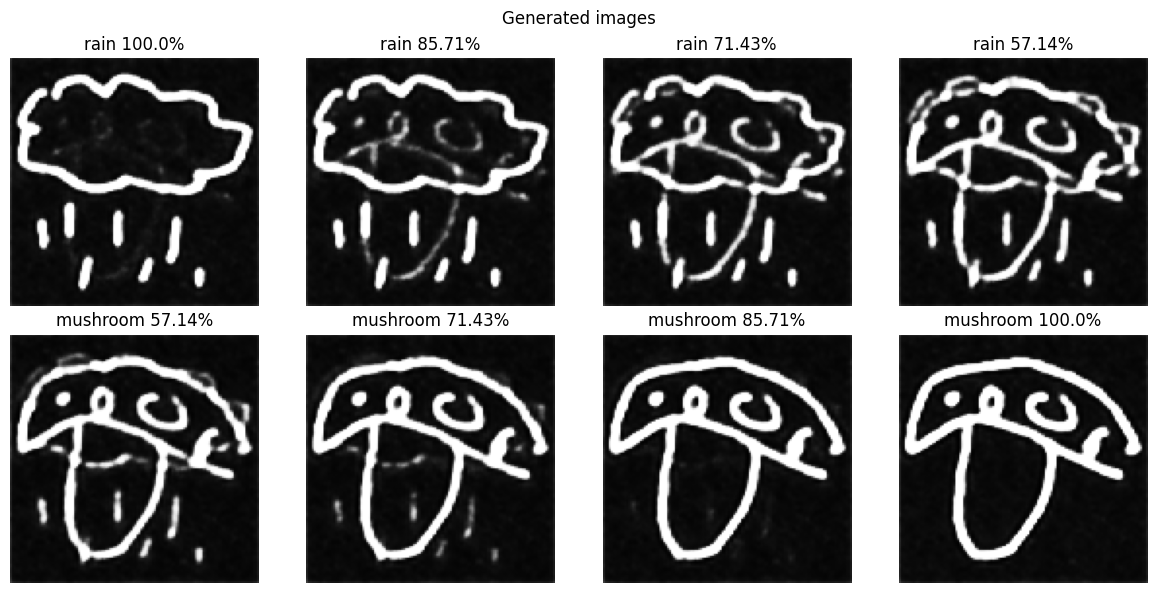

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]

embed_class2 = autoencoder_model.get_embed(label2.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class2).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class2).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class m => z' (class m) + embed_class n, n !=m

8


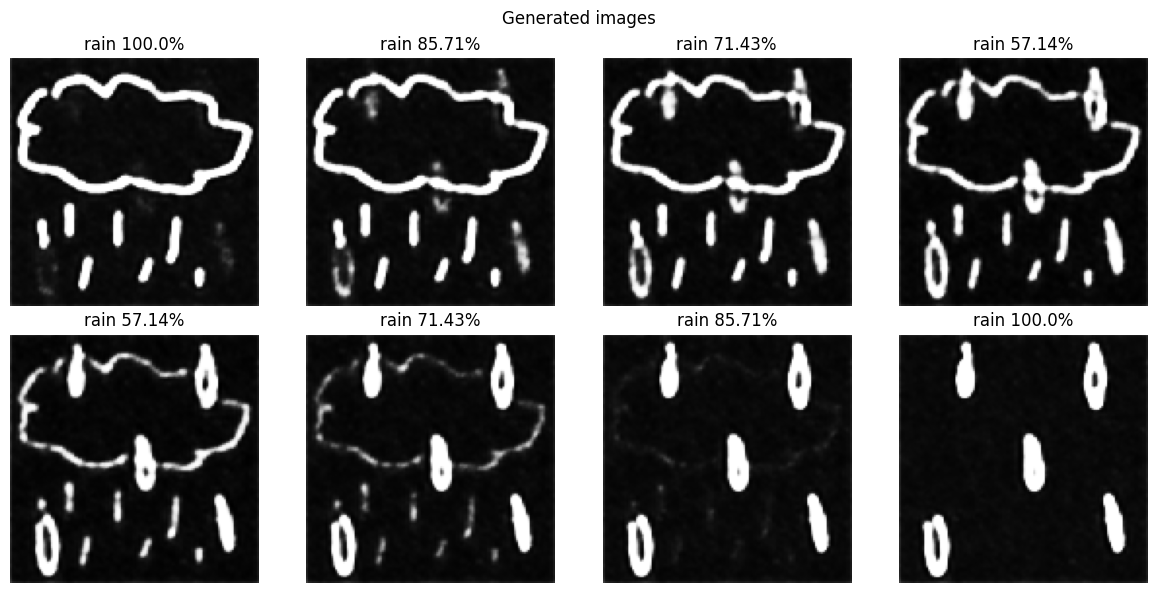

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with the same label
indice2 = 1
image_2, label2 = None, None

while label2 != label1:
    image_2, label2 = training_set[indice2]
    indice2 +=1



# iterate over all images to find the first image with not the same label
embed_index = 0
while training_set[embed_index][1] == label2:
    embed_index += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)

pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]


label_other = torch.tensor(training_set[embed_index][1]).to(device)
embed_class_other = autoencoder_model.get_embed(label_other.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class_other).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class_other).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))
